In [1]:
import os
import yaml

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange


Bad key text.latex.unicode in file /home/nhat/miniconda3/envs/salsanext/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/nhat/miniconda3/envs/salsanext/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/nhat/miniconda3/envs/salsanext/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get

In [2]:
HOMEDIR = os.environ['HOME']
COURSEDIR = f"{HOMEDIR}/work/uq/engg4811"
# PREDDIR = f"{COURSEDIR}/trainlogs/bracewell01/salsa" #2021-10-12-16:20rellis  salsa
PREDDIR = f"{COURSEDIR}/trainlogs/ec2-01/salsa"
DATADIR = f"{COURSEDIR}/datasets/Rellis-3D"

In [3]:
DATA_CONFIG_FILE = "../train/tasks/semantic/config/labels/rellis.yaml"
CONFIG = yaml.safe_load(open(DATA_CONFIG_FILE, 'r'))

In [58]:
CONFIG

{'name': 'rellis',
 'labels': {0: 'void',
  1: 'dirt',
  3: 'grass',
  4: 'tree',
  5: 'pole',
  6: 'water',
  7: 'sky',
  8: 'vehicle',
  9: 'object',
  10: 'asphalt',
  12: 'building',
  15: 'log',
  17: 'person',
  18: 'fence',
  19: 'bush',
  23: 'concrete',
  27: 'barrier',
  31: 'puddle',
  33: 'mud',
  34: 'rubble'},
 'color_map': {0: [0, 0, 0],
  1: [108, 64, 20],
  3: [0, 102, 0],
  4: [0, 255, 0],
  5: [0, 153, 153],
  6: [0, 128, 255],
  7: [0, 0, 255],
  8: [255, 255, 0],
  9: [255, 0, 127],
  10: [64, 64, 64],
  12: [255, 0, 0],
  15: [102, 0, 0],
  17: [204, 153, 255],
  18: [102, 0, 204],
  19: [255, 153, 204],
  23: [170, 170, 170],
  27: [41, 121, 255],
  31: [134, 255, 239],
  33: [99, 66, 34],
  34: [110, 22, 138]},
 'content': {0: 447156890,
  1: 0,
  3: 261005182,
  4: 107172982,
  5: 22852,
  6: 224173,
  7: 0,
  8: 111345,
  9: 2,
  10: 479,
  12: 10,
  15: 554091,
  17: 10626325,
  18: 1588416,
  19: 168764964,
  23: 10944799,
  27: 3502156,
  31: 1493276,
  33:

In [4]:
# Map labels to class ids
CID_MAP = CONFIG['learning_map']

In [5]:
# Map class ids to class names
NAME_MAP = dict()
for cid, label in CONFIG['learning_map_inv'].items():
    NAME_MAP[cid] = CONFIG['labels'][label]
    
CLASS_NAMES = [NAME_MAP[i] for i in range(len(NAME_MAP))]

In [14]:
"""
Get a vector of labels
"""
def get_labels(filepath):
    return np.fromfile(filepath, dtype=np.int32).reshape((-1))

In [7]:
"""
Convert a label vector to a class id vector
"""
def labels_to_cids(labels):
    tmp = labels.copy()
    for k, v in CID_MAP.items():
        labels[tmp == k] = v
    return labels

In [8]:
"""
Get confusion matrix given a ground truth vector and a prediction vector

g -- ground truth
p -- prediction
n -- number of classes
ignore -- ignore class ids

"""
def calc_confusion_matrix(g, p, n, ignore_class_ids):
    for cid in ignore_class_ids:
        g = g[g != cid]
        p = p[p != cid]
    
    # compare[i] = g[i] * n + p[i]: prediction for
    # point i is pred[i] where ground truth is labels[i]
    compare = g * n + p
    
    # bins[g[i] * n + p[j]]: number of points with
    #     ground-truth g[i] and are predicted to be p[j]
    bins = np.bincount(compare)
    # pad with zeros
    bins = np.pad(bins, (0, n * n - len(bins)), 'constant')
    assert(bins.shape[0] == n * n)
    
    cm = np.zeros((n, n), dtype=np.int32)
    for gcid in range(n):
        for pcid in range(n):
            cm[gcid, pcid] = bins[gcid * n + pcid]
    return cm

In [64]:
def plot_iou(title, iou):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1.5, 1.5])
    ax.bar(CLASS_NAMES, iou)
    ax.set_xlabel('Semantic classes')
    ax.set_ylabel('IoU')
    ax.set_title(f'IoU of all semantic classes\n{title}')
    plt.show()

# plot_iou('SalsaNext training on 1 GPU, batch size = 7')

In [22]:
class Evaluator:
    def __init__(self, data_dir, pred_dir, desc):
        self.data_dir = data_dir
        self.pred_dir = pred_dir
        self.desc = desc
        self.iou = None
        self.mean_iou = None

    def calc_iou(self):
        label_filenames = []

        with open(f'{self.data_dir}/pt_test.lst', 'r') as f:
            for line in f:
                input_file_name, label_filename = line.strip().split(' ')
                label_filenames.append(label_filename)

        n = len(CLASS_NAMES)
        cm = np.zeros((n, n), dtype=np.int32)

        for fname in tqdm(label_filenames):
            glabels = get_labels(f'{self.data_dir}/{fname}')
            plabels = get_labels(f'{self.pred_dir}/{fname}')
            g = labels_to_cids(glabels)
            p = labels_to_cids(plabels)
            bins = np.bincount(g)
            cm += calc_confusion_matrix(g, p, n, [])

        iou = (np.diag(cm) / np.maximum(1.0, cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm)))
        self.iou = iou
        self.mean_iou = iou.mean()
        return self.iou, self.mean_iou
    
    def plot_iou(self):
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1.5, 1.5])
        ax.bar(CLASS_NAMES, self.iou)
        ax.set_xlabel('Semantic classes')
        ax.set_ylabel('IoU')
        ax.set_title(f'IoU of all semantic classes\n{self.desc}')
        plt.show()

In [23]:
bracewell_evaluator = Evaluator(
    data_dir = f'{COURSEDIR}/datasets/Rellis-3D',
    pred_dir = f'{COURSEDIR}/trainlogs/bracewell01/salsa',
    desc     = 'training on 2 GPU, batch size = 12'
)

In [24]:
ec2_evaluator = Evaluator(
    data_dir = f'{COURSEDIR}/datasets/Rellis-3D',
    pred_dir = f'{COURSEDIR}/trainlogs/ec2-01/salsa',
    desc     = 'training on 1 GPU, batch size = 7'
)

In [25]:
bracewell_evaluator.calc_iou()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3343/3343 [00:26<00:00, 126.25it/s]


(array([0.00000000e+00, 6.31296815e-01, 6.27230400e-01, 1.06237230e-01,
        0.00000000e+00, 1.80485843e-01, 1.66911910e-03, 2.99500717e-02,
        2.03421673e-02, 5.78547076e-01, 5.32406087e-01, 2.94245267e-01,
        2.22003223e-01, 6.43308310e-02, 6.01974476e-04]),
 0.2192897402859991)

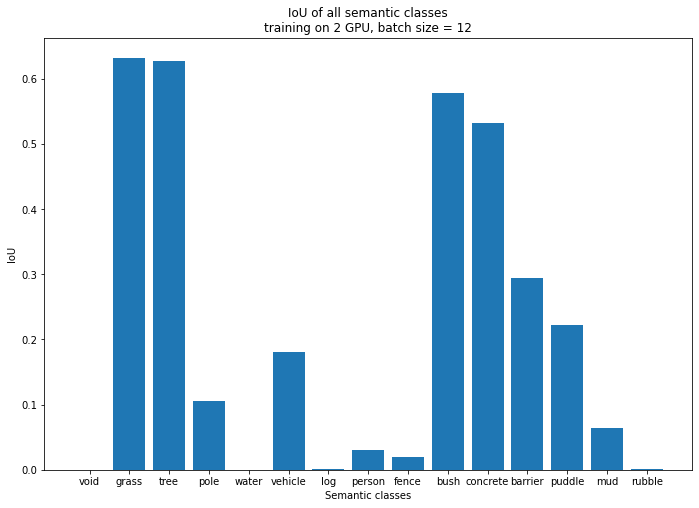

In [26]:
bracewell_evaluator.plot_iou()

In [27]:
ec2_evaluator.calc_iou()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3343/3343 [00:26<00:00, 127.12it/s]


(array([0.        , 0.6351376 , 0.55123083, 0.04137939, 0.        ,
        0.14487659, 0.052691  , 0.0344269 , 0.02428534, 0.50979746,
        0.55691995, 0.66751511, 0.21847499, 0.10851241, 0.01055645]),
 0.23705360124698946)

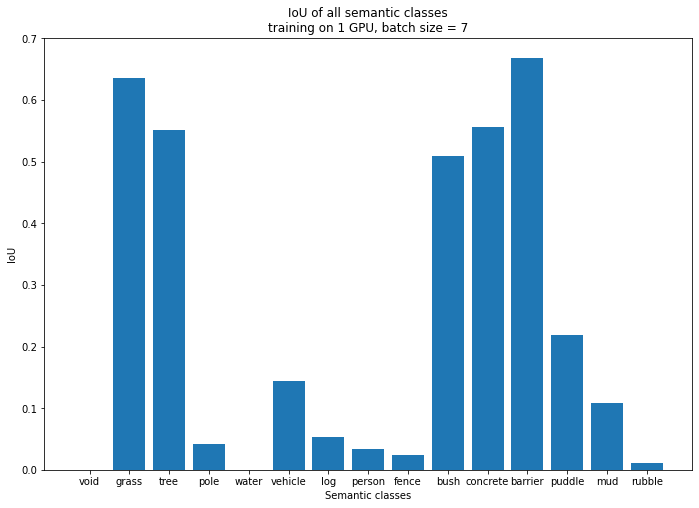

In [28]:
ec2_evaluator.plot_iou()